# Сборный проект-4
Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

# импорт библиотек в питон

In [ ]:
pip install -q catboost sentence-transformers ansicolors clip

In [ ]:
pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import warnings
from colors import red

import clip

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from sentence_transformers import SentenceTransformer,util

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from pathlib import Path

from sklearn.model_selection import cross_val_score, GroupShuffleSplit,GridSearchCV

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from catboost import CatBoostRegressor
from catboost import  Pool

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

In [ ]:
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords_set = set(stopwords.words('english'))
lemmatize = WordNetLemmatizer()
model = SentenceTransformer('clip-ViT-B-16',device='cuda')


scaler = MinMaxScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH= '/content/drive/MyDrive/to_upload/'
PATH= '/content/drive/MyDrive/to_upload/'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#функции

#### функия анализа данных

In [ ]:
def data_analis (df,  i  = True,
                  h  = True,
                  ds = True,
                  dp = True,
                  isna=True):

  if i == True:
    i=df.info()
    i

  if h == True:
    h = df.head()
    display(h)

  if ds == True:
    ds = df.describe()
    display(ds)

  if dp == True:
    dp = df.duplicated().sum()
    print('дубликаты:',dp)

  if isna == True:
    isna = df.isna().sum()
    miss = df.isna().sum() * 100 / len(df)
    display(pd.DataFrame({'пропуски':isna,'% потерь':miss}))

#### функия загркзки фото для просмотра

In [ ]:
def photo_load (dir,clas='train',size=0):
  if clas =='train':
    photo_train = list(train_set['image'].sample(size))
  if clas == 'test':
    photo_test = list(img_test['image'].sample(size))

  fig = plt.figure(figsize=(10,10))

  for i in range(size):
      fig.add_subplot(3, 3,i+1)
      if clas =='train':
        image_path =os.path.join(dir, photo_train[i])
        plt.title(photo_train[i])
      if clas == 'test':
        image_path =os.path.join(dir, photo_test[i])
        plt.title(photo_test[i])
      image1 = Image.open(image_path)
      plt.imshow(image1)
      plt.xticks([])
      plt.yticks([])

####функция леммитизации текста

In [ ]:
def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    tokens = nltk.word_tokenize(text)
    lemmas = [lemmatize.lemmatize(word) for word in tokens]
    return lemmas

####функция загрузки изображений для модели


In [ ]:
def load_train(path=DATA_PATH, img_size=(224, 224), batch_size=64,clas='train') -> ImageDataGenerator:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    if clas=='train':
      train_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=filtered_train_dataset,
          directory=Path(path, 'train_images'),
          x_col='image',
          y_col='final_score',
          target_size=img_size,
          batch_size=batch_size,
          class_mode='raw',
          shuffle=False,
          seed=3826)
      return train_gen_flow
    if clas == 'test':
      test_gen_flow = train_datagen.flow_from_dataframe(
          dataframe=quer_test,
          directory=Path(path, 'test_images'),
          x_col='image',
          target_size=img_size,
          batch_size=batch_size,
          class_mode=None,
          shuffle=False,
          seed=3826)
      return test_gen_flow

#### функция создания сверточной модели

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    backbone = Xception(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

#загрузка данных

In [ ]:
anot_ots=pd.read_table(os.path.join(DATA_PATH,'CrowdAnnotations.tsv'), sep='\t',
                               names=['image', 'query_id', 'dol', 'col_poz', 'col_neg'])
anot_exp=pd.read_table(os.path.join(DATA_PATH,'ExpertAnnotations.tsv'), sep='\t',
                                names=['image', 'query_id', 'first', 'second', 'third'])

train_set=pd.read_csv(os.path.join(DATA_PATH,'train_dataset.csv'))

img_test=pd.read_csv(os.path.join(DATA_PATH,'test_images.csv'),sep='|')
quer_test=pd.read_csv(os.path.join(DATA_PATH,'test_queries.csv'),sep='|', on_bad_lines='skip',index_col=0)

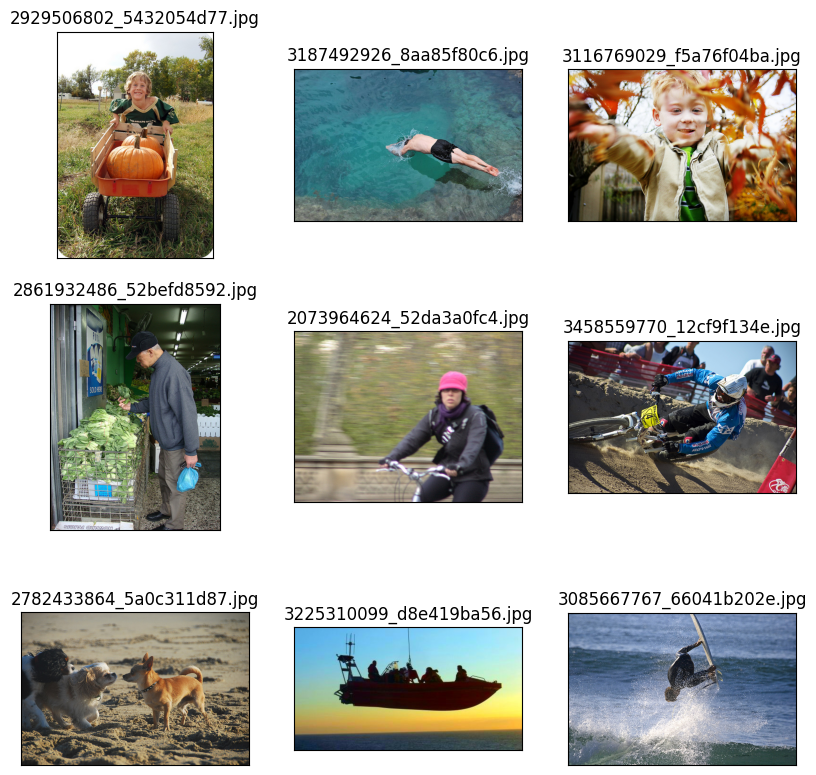

In [ ]:
photo_load(os.path.join(DATA_PATH, 'train_images'),'train',9)

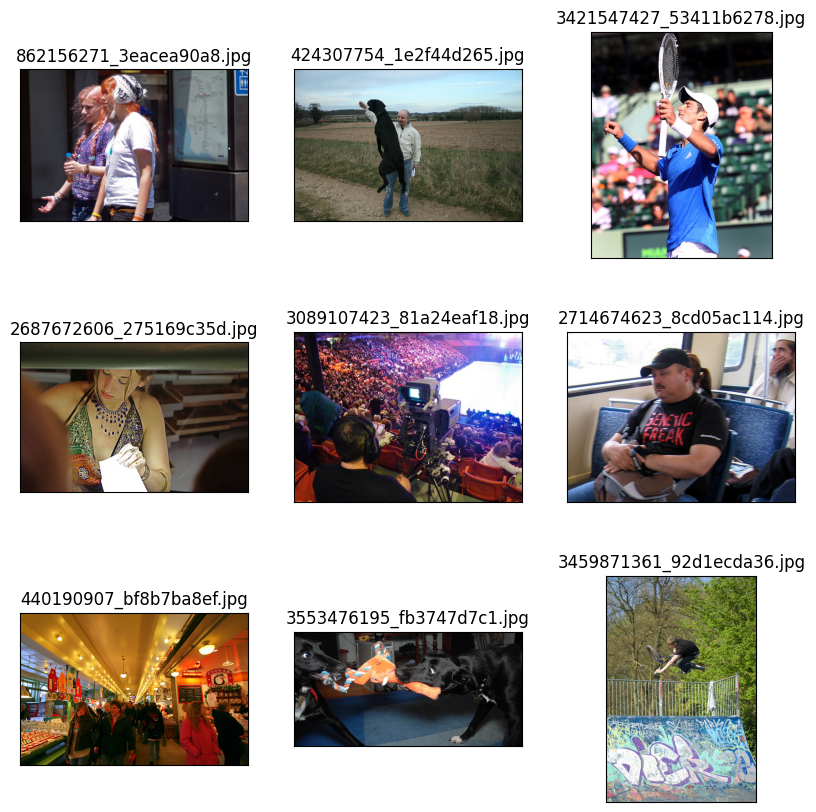

In [ ]:
photo_load(os.path.join(DATA_PATH, 'test_images'),'test' ,9)

# Исследовательский анализ данных

In [ ]:
data_analis (anot_ots,ds=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   dol       47830 non-null  float64
 3   col_poz   47830 non-null  int64  
 4   col_neg   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,dol,col_poz,col_neg
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


дубликаты: 0


,пропуски,% потерь
image,0,0.0
query_id,0,0.0
dol,0,0.0
col_poz,0,0.0
col_neg,0,0.0


In [ ]:
data_analis (anot_exp,ds=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,first,second,third
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


дубликаты: 0


,пропуски,% потерь
image,0,0.0
query_id,0,0.0
first,0,0.0
second,0,0.0
third,0,0.0


In [ ]:
data_analis (train_set,ds=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


дубликаты: 0


,пропуски,% потерь
image,0,0.0
query_id,0,0.0
query_text,0,0.0


In [ ]:
data_analis (img_test,ds=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


дубликаты: 0


,пропуски,% потерь
image,0,0.0


In [ ]:
data_analis(quer_test,ds=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


дубликаты: 0


,пропуски,% потерь
query_id,0,0.0
query_text,0,0.0
image,0,0.0


In [ ]:
print('уникальные фото в трейне:', len(train_set['image'].unique()))
print('уникальные фото в тесте:', len(quer_test['image'].unique()))
print('совпадающие картинки:', len(set(train_set['image']) & set(quer_test['image'])))

print('текстовые описаний в трейне:', len(set(train_set['query_text'])))
print('текстовые описаний в тесте:', len(set(quer_test['query_text'])))
print('совпадающие описания:', len(set(train_set['query_text']) & set(quer_test['query_text'])))

уникальные фото в трейне: 1000
уникальные фото в тесте: 100
совпадающие картинки: 0
текстовые описаний в трейне: 977
текстовые описаний в тесте: 500
совпадающие описания: 0


# переработка данных

In [ ]:
def result_expert(row):
    res = [0, 0, 0, 0]
    for i in [2, 3, 4]:
        res[int(row[i]-1)] += 1
    if max(res) == 1:
        return None
    else:
        return res.index(max(res)) + 1

In [ ]:
anot_exp['result'] = anot_exp.apply(result_expert, axis=1)
anot_exp['result'] = anot_exp['result'] / 4.0
anot_exp.drop(columns=['first', 'second', 'third'],axis=1 , inplace=True)
display(anot_exp.head())
anot_exp.info()
print(f"Количество None: {anot_exp['result'].isna().sum()}")
anot_exp.dropna(subset=['result'], inplace=True)
print(f"Количество None: {anot_exp['result'].isna().sum()}")

,image,query_id,result
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     5822 non-null   object 
 1   query_id  5822 non-null   object 
 2   result    5696 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB
Количество None: 126
Количество None: 0


In [ ]:
anot_ots.drop(columns=['col_poz', 'col_neg'], axis=1, inplace=True)
anot_ots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   dol       47830 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
anot_ots.isna().sum()

image       0
query_id    0
dol         0
dtype: int64

In [ ]:
anot = anot_exp.merge(anot_ots, on=['image', 'query_id'], how='outer')
display(anot.head(5))
print('')
anot.info()
print(' ')
display(pd.DataFrame({'% пропусков': anot.isna().sum() * 100 / len(anot),'количество пропусков': anot.isna().sum()}))

,image,query_id,result,dol
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.25,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.25,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.25,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.50,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.25,NaN



<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     51268 non-null  object 
 1   query_id  51268 non-null  object 
 2   result    5696 non-null   float64
 3   dol       47830 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB
 


,% пропусков,количество пропусков
image,0.000000,0
query_id,0.000000,0
result,88.889756,45572
dol,6.705937,3438


In [ ]:
def combine_scores(row):
    if pd.notna(row['result']):
        return row['result']
    elif pd.notna(row['dol']):
        return row['dol']

In [ ]:
anot['final_score'] = anot.apply(combine_scores, axis=1)
anot.drop(columns=['result', 'dol'], axis=1,inplace=True)

In [ ]:
display(anot.head())
print('')
anot.info()
print('')
display(pd.DataFrame({'% пропусков': anot.isna().sum() * 100 / len(anot),'количество пропусков': anot.isna().sum()}))

,image,query_id,final_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.25
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.25
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.25
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.50
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.25



<class 'pandas.core.frame.DataFrame'>
Int64Index: 51268 entries, 0 to 51267
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51268 non-null  object 
 1   query_id     51268 non-null  object 
 2   final_score  51268 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB



,% пропусков,количество пропусков
image,0.0,0
query_id,0.0,0
final_score,0.0,0


In [ ]:
training_data = train_set.merge(anot, left_on=['image', 'query_id'], right_on=['image', 'query_id'], how='left')

In [ ]:
unique_query_texts = training_data.dropna(subset=['query_text'])[['query_id', 'query_text']].drop_duplicates()

In [ ]:
training_data = training_data.merge(unique_query_texts, on='query_id', how='left', suffixes=('', '_fill'))

In [ ]:
training_data['query_text'] = training_data['query_text'].fillna(training_data['query_text_fill'])

In [ ]:
training_data.drop(columns=['query_text_fill'], inplace=True)

In [ ]:
display(training_data.head())
display(pd.DataFrame({'% пропусков': training_data.isna().sum() * 100 / len(training_data),'количество пропусков': training_data.isna().sum()}))
training_data.dropna(inplace=True)
display(pd.DataFrame({'% пропусков': training_data.isna().sum() * 100 / len(training_data),'количество пропусков': training_data.isna().sum()}))
print()
print(f'размер выборки: {len(training_data)}')

,image,query_id,query_text,final_score,forbidden
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.50,True
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.00,True
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True


,% пропусков,количество пропусков
image,0.0,0
query_id,0.0,0
query_text,0.0,0
final_score,0.0,0
forbidden,0.0,0


,% пропусков,количество пропусков
image,0.0,0
query_id,0.0,0
query_text,0.0,0
final_score,0.0,0
forbidden,0.0,0



размер выборки: 5767


### вывод по главе "Исследовательский анализ данных":
 - посмотрели на данные, аномалии в данных
 - первично обработали данные
    - привели оценки к виду от 0 до 1
    - удалили лишние оценки
    - обьеденили датасет с оценками экспертов и краудфандинговыми оценками
    - добавили обьедененный датасет с оценками к датасету с анотациями
    - обьединили основной тренировочный датасет с датасетом анотаций
    
  итогом стал один датасет с изображениями, аноациями к изображениям, оценкой соответствия анотации изоброжению

#Проверка данных

##Очистка датасета.

#### Функция для проверки наличия запрещенных слов в описании

In [ ]:
forbidden_words = ['child', 'children', 'baby', 'babies', 'boy', 'boys', 'girl', 'girls', 'teenager', 'schoolboy', 'kid', 'kids',
                   'infant', 'infants', 'toddler', 'toddlers', 'newborn']

def have_forbidden_words(text, forbidden_list):
    lemmatized_text = process_text(text)
    return any(word in lemmatized_text for word in forbidden_list)

In [ ]:
training_data['forbidden'] = training_data['query_text'].apply(lambda x: have_forbidden_words(x, forbidden_words))
bad_images = training_data[training_data['forbidden']]['query_id'].apply(lambda x: x[:-2]).unique()

filtered_train_dataset = training_data[~training_data['image'].isin(bad_images)]

initial_size = training_data.shape[0]
final_size = filtered_train_dataset.shape[0]
print(f"было изображений: {initial_size} изображений стало: {final_size}",sep='/n')
print(f"Удалено {initial_size - final_size} изображений")

было изображений: 5767 изображений стало: 4052
Удалено 1715 изображений


In [ ]:
display(filtered_train_dataset.head(5))

,image,query_id,query_text,final_score,forbidden
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.25,True


## Векторизация текстов (train)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords_set))
tfidf_train = tfidf_vectorizer.fit_transform(filtered_train_dataset['query_text'])
print("Размер матрицы для обучающего набора (текст):", tfidf_train.shape)

Размер матрицы для обучающего набора (текст): (4052, 1406)


#### функция векторизации

In [ ]:
#def vectorize_pictures_1(model, train_data,txt):
#    photo = model.encode(train_data, batch_size=128, convert_to_tensor=True, show_progress_bar=True)
#    txt = model.encode(txt,batch_size=128, convert_to_tensor=True, show_progress_bar=True)
#    predictions=util.cos_sim(photo,txt)
#    return predictions

In [ ]:
def vectorize_pictures(model, train_data):
    predictions = model.predict(train_data)
    return predictions

In [ ]:
%%time
pict_embeds = vectorize_pictures(create_model(), load_train())

Found 4052 validated image filenames.
64/64 [==============================] - 46s 593ms/step
CPU times: user 39 s, sys: 6.56 s, total: 45.5 s
Wall time: 1min 33s


In [ ]:
pict_embeds.shape

(4052, 2048)

## Объединение векторов (train)

np.hstack([np.vstack(pict_embeds), tfidf_train.toarray()])

In [ ]:
combined_features_train = np.hstack([np.vstack(pict_embeds), tfidf_train.toarray()])
print("Размер объединенного датасета:", combined_features_train.shape)

Размер объединенного датасета: (4052, 3454)


### вывод по главе "Проверка данных":

- удалили изображения которые по тем или иным причинам нельзя использовать для обучения модели
- превратили в векторы изображения и анотации
-соеденили два дата сета с векторами в один

# Обучение модели предсказания соответствия

## Подготовим обучающую и тестовые выборки

In [ ]:
# Выделяем признаки и целевую переменную
X = combined_features_train
y = filtered_train_dataset['final_score']
groups = filtered_train_dataset['image']

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=3826)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=groups))
X_train, X_valid = X[train_indices], X[test_indices]
y_train, y_valid = y.iloc[train_indices], y.iloc[test_indices]

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

## LinearRegression

буду использовать метрику MSE т.к. эта метрика является самой популярной для оценивания регресиии, она достаточна стабильна в своих показателях т.к. показывает сколько данных потеряла модель при обучении.

MSE - метрика, которая сообщает о средней квадратичной разницы между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже MSE, тем лучше модель соответствует набору данных.

MSE рассчитывается так:

СКО =  Σ(ŷ i – y i ) 2 / n

где:

- Σ — это символ, который означает «сумма»
- ŷ i - прогнозируемое значение для i -го наблюдения
- y i - наблюдаемое значение для i -го наблюдения
- n - размер выборки

In [ ]:
%%time
model_lr = LinearRegression(positive=True)
model_lr.fit(X_train, y_train)
RMSE_lr = mean_squared_error(y_valid, model_lr.predict(X_valid))

CPU times: user 29.5 s, sys: 267 ms, total: 29.7 s
Wall time: 36.4 s


### catboost

In [ ]:
grid = {
        'iterations': [100],
        'learning_rate': [1,0.1],
        'depth': [2,5,7]
       }
model_cat= CatBoostRegressor(loss_function='RMSE', eval_metric='RMSE', task_type="GPU")

In [ ]:
catboost_grid = GridSearchCV(estimator=model_cat,
                                   param_grid=grid,
                                      cv=3,
                                  verbose=2)

In [ ]:
%%time
catboost_grid.fit(X_train,y_train)
best_model_CB = catboost_grid.best_estimator_
final_metrics_CB = best_model_CB.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


0:	learn: 0.2164370	total: 38.6ms	remaining: 3.83s
1:	learn: 0.2159315	total: 71.3ms	remaining: 3.49s
2:	learn: 0.2116124	total: 101ms	remaining: 3.28s
3:	learn: 0.2093492	total: 131ms	remaining: 3.14s
4:	learn: 0.2078403	total: 156ms	remaining: 2.96s
5:	learn: 0.2069462	total: 179ms	remaining: 2.81s
6:	learn: 0.2062842	total: 211ms	remaining: 2.8s
7:	learn: 0.2039096	total: 263ms	remaining: 3.03s
8:	learn: 0.2010829	total: 289ms	remaining: 2.92s
9:	learn: 0.1998631	total: 318ms	remaining: 2.86s
10:	learn: 0.1983613	total: 354ms	remaining: 2.86s
11:	learn: 0.1972510	total: 392ms	remaining: 2.88s
12:	learn: 0.1960014	total: 418ms	remaining: 2.8s
13:	learn: 0.1951433	total: 449ms	remaining: 2.76s
14:	learn: 0.1943336	total: 486ms	remaining: 2.76s
15:	learn: 0.1936299	total: 519ms	remaining: 2.72s
16:	learn: 0.1930068	total: 546ms	remaining: 2.67s
17:	learn: 0.1917645	total: 576ms	remaining: 2.62s
18:	learn: 0.1913823	total: 621ms	remaining: 2.65s
19:	learn: 0.1909375	total: 669ms	remaini

0:	learn: 0.2277902	total: 15.2ms	remaining: 1.51s
1:	learn: 0.2213676	total: 32.6ms	remaining: 1.59s
2:	learn: 0.2204205	total: 42.1ms	remaining: 1.36s
3:	learn: 0.2191130	total: 55.5ms	remaining: 1.33s
4:	learn: 0.2177952	total: 64.9ms	remaining: 1.23s
5:	learn: 0.2157382	total: 74.4ms	remaining: 1.17s
6:	learn: 0.2114096	total: 84.1ms	remaining: 1.12s
7:	learn: 0.2101335	total: 93.7ms	remaining: 1.08s
8:	learn: 0.2080690	total: 103ms	remaining: 1.04s
9:	learn: 0.2062437	total: 122ms	remaining: 1.1s
10:	learn: 0.2040225	total: 132ms	remaining: 1.07s
11:	learn: 0.2021348	total: 142ms	remaining: 1.04s
12:	learn: 0.2016223	total: 162ms	remaining: 1.08s
13:	learn: 0.1994860	total: 170ms	remaining: 1.04s
14:	learn: 0.1984769	total: 179ms	remaining: 1.01s
15:	learn: 0.1970923	total: 200ms	remaining: 1.05s
16:	learn: 0.1964375	total: 223ms	remaining: 1.09s
17:	learn: 0.1956479	total: 230ms	remaining: 1.05s
18:	learn: 0.1947683	total: 240ms	remaining: 1.02s
19:	learn: 0.1938714	total: 248ms	

0:	learn: 0.2190132	total: 13.6ms	remaining: 1.34s
1:	learn: 0.2166731	total: 26.5ms	remaining: 1.3s
2:	learn: 0.2148109	total: 35.2ms	remaining: 1.14s
3:	learn: 0.2123606	total: 55.7ms	remaining: 1.34s
4:	learn: 0.2110003	total: 70.5ms	remaining: 1.34s
5:	learn: 0.2099744	total: 79ms	remaining: 1.24s
6:	learn: 0.2083105	total: 92.6ms	remaining: 1.23s
7:	learn: 0.2073512	total: 101ms	remaining: 1.16s
8:	learn: 0.2067155	total: 110ms	remaining: 1.11s
9:	learn: 0.2044438	total: 118ms	remaining: 1.06s
10:	learn: 0.2036749	total: 135ms	remaining: 1.09s
11:	learn: 0.2018867	total: 149ms	remaining: 1.09s
12:	learn: 0.2000484	total: 162ms	remaining: 1.08s
13:	learn: 0.1984386	total: 185ms	remaining: 1.14s
14:	learn: 0.1974636	total: 206ms	remaining: 1.16s
15:	learn: 0.1956399	total: 232ms	remaining: 1.22s
16:	learn: 0.1952811	total: 250ms	remaining: 1.22s
17:	learn: 0.1946286	total: 268ms	remaining: 1.22s
18:	learn: 0.1936777	total: 285ms	remaining: 1.22s
19:	learn: 0.1927635	total: 303ms	rem

0:	learn: 0.2202169	total: 18.7ms	remaining: 1.85s
1:	learn: 0.2193856	total: 35.4ms	remaining: 1.74s
2:	learn: 0.2187039	total: 52.4ms	remaining: 1.69s
3:	learn: 0.2178955	total: 68.6ms	remaining: 1.65s
4:	learn: 0.2173986	total: 85.5ms	remaining: 1.62s
5:	learn: 0.2165541	total: 102ms	remaining: 1.6s
6:	learn: 0.2160334	total: 119ms	remaining: 1.58s
7:	learn: 0.2155732	total: 130ms	remaining: 1.49s
8:	learn: 0.2148889	total: 142ms	remaining: 1.43s
9:	learn: 0.2143808	total: 149ms	remaining: 1.34s
10:	learn: 0.2138328	total: 157ms	remaining: 1.27s
11:	learn: 0.2135782	total: 164ms	remaining: 1.2s
12:	learn: 0.2133067	total: 178ms	remaining: 1.19s
13:	learn: 0.2132050	total: 195ms	remaining: 1.2s
14:	learn: 0.2128129	total: 217ms	remaining: 1.23s
15:	learn: 0.2123713	total: 238ms	remaining: 1.25s
16:	learn: 0.2120095	total: 258ms	remaining: 1.26s
17:	learn: 0.2115963	total: 274ms	remaining: 1.25s
18:	learn: 0.2111981	total: 291ms	remaining: 1.24s
19:	learn: 0.2106621	total: 312ms	remai

0:	learn: 0.2313730	total: 7.56ms	remaining: 748ms
1:	learn: 0.2299903	total: 14.6ms	remaining: 717ms
2:	learn: 0.2286307	total: 20.8ms	remaining: 674ms
3:	learn: 0.2274331	total: 31.7ms	remaining: 761ms
4:	learn: 0.2262670	total: 38.7ms	remaining: 736ms
5:	learn: 0.2254755	total: 48.4ms	remaining: 758ms
6:	learn: 0.2247962	total: 56.2ms	remaining: 747ms
7:	learn: 0.2240526	total: 62.4ms	remaining: 718ms
8:	learn: 0.2232136	total: 68.6ms	remaining: 694ms
9:	learn: 0.2225755	total: 74.7ms	remaining: 673ms
10:	learn: 0.2218656	total: 80.8ms	remaining: 654ms
11:	learn: 0.2214583	total: 87ms	remaining: 638ms
12:	learn: 0.2208541	total: 93.1ms	remaining: 623ms
13:	learn: 0.2200803	total: 99.2ms	remaining: 609ms
14:	learn: 0.2196431	total: 105ms	remaining: 597ms
15:	learn: 0.2192617	total: 111ms	remaining: 585ms
16:	learn: 0.2186196	total: 120ms	remaining: 587ms
17:	learn: 0.2181333	total: 126ms	remaining: 576ms
18:	learn: 0.2177900	total: 133ms	remaining: 565ms
19:	learn: 0.2172581	total: 1

0:	learn: 0.2282538	total: 9.1ms	remaining: 901ms
1:	learn: 0.2271157	total: 15.4ms	remaining: 754ms
2:	learn: 0.2260025	total: 21.5ms	remaining: 695ms
3:	learn: 0.2257333	total: 28.1ms	remaining: 673ms
4:	learn: 0.2252009	total: 34.2ms	remaining: 649ms
5:	learn: 0.2247136	total: 40.2ms	remaining: 630ms
6:	learn: 0.2233382	total: 46.2ms	remaining: 614ms
7:	learn: 0.2225096	total: 52.5ms	remaining: 603ms
8:	learn: 0.2221591	total: 58.6ms	remaining: 593ms
9:	learn: 0.2217869	total: 64.8ms	remaining: 583ms
10:	learn: 0.2207187	total: 70.9ms	remaining: 574ms
11:	learn: 0.2203041	total: 77.1ms	remaining: 565ms
12:	learn: 0.2199220	total: 83.2ms	remaining: 557ms
13:	learn: 0.2186520	total: 89.3ms	remaining: 548ms
14:	learn: 0.2182446	total: 95.4ms	remaining: 541ms
15:	learn: 0.2178165	total: 102ms	remaining: 534ms
16:	learn: 0.2173743	total: 112ms	remaining: 547ms
17:	learn: 0.2167886	total: 118ms	remaining: 539ms
18:	learn: 0.2165175	total: 124ms	remaining: 530ms
19:	learn: 0.2161212	total:

0:	learn: 0.2061223	total: 23.9ms	remaining: 2.36s
1:	learn: 0.2043868	total: 43.5ms	remaining: 2.13s
2:	learn: 0.2011350	total: 63.2ms	remaining: 2.04s
3:	learn: 0.1982555	total: 84.7ms	remaining: 2.03s
4:	learn: 0.1919135	total: 106ms	remaining: 2.02s
5:	learn: 0.1892023	total: 128ms	remaining: 2s
6:	learn: 0.1862950	total: 150ms	remaining: 2s
7:	learn: 0.1847558	total: 170ms	remaining: 1.95s
8:	learn: 0.1820232	total: 193ms	remaining: 1.95s
9:	learn: 0.1805629	total: 214ms	remaining: 1.93s
10:	learn: 0.1790531	total: 236ms	remaining: 1.91s
11:	learn: 0.1769266	total: 252ms	remaining: 1.85s
12:	learn: 0.1758980	total: 267ms	remaining: 1.79s
13:	learn: 0.1740161	total: 282ms	remaining: 1.73s
14:	learn: 0.1734527	total: 296ms	remaining: 1.68s
15:	learn: 0.1707929	total: 312ms	remaining: 1.64s
16:	learn: 0.1690524	total: 328ms	remaining: 1.6s
17:	learn: 0.1681416	total: 344ms	remaining: 1.57s
18:	learn: 0.1672868	total: 358ms	remaining: 1.53s
19:	learn: 0.1665556	total: 373ms	remaining:

0:	learn: 0.2222892	total: 23.2ms	remaining: 2.3s
1:	learn: 0.2121978	total: 43ms	remaining: 2.1s
2:	learn: 0.2066247	total: 66.1ms	remaining: 2.14s
3:	learn: 0.2007597	total: 87.3ms	remaining: 2.1s
4:	learn: 0.1963307	total: 108ms	remaining: 2.06s
5:	learn: 0.1933139	total: 128ms	remaining: 2.01s
6:	learn: 0.1909643	total: 149ms	remaining: 1.98s
7:	learn: 0.1881438	total: 169ms	remaining: 1.94s
8:	learn: 0.1856131	total: 187ms	remaining: 1.89s
9:	learn: 0.1835917	total: 203ms	remaining: 1.83s
10:	learn: 0.1810997	total: 219ms	remaining: 1.77s
11:	learn: 0.1785438	total: 241ms	remaining: 1.77s
12:	learn: 0.1768018	total: 256ms	remaining: 1.71s
13:	learn: 0.1736421	total: 273ms	remaining: 1.68s
14:	learn: 0.1721844	total: 288ms	remaining: 1.63s
15:	learn: 0.1688403	total: 303ms	remaining: 1.59s
16:	learn: 0.1676414	total: 321ms	remaining: 1.56s
17:	learn: 0.1665498	total: 335ms	remaining: 1.53s
18:	learn: 0.1642519	total: 352ms	remaining: 1.5s
19:	learn: 0.1635498	total: 366ms	remaining

0:	learn: 0.2096445	total: 44.2ms	remaining: 4.38s
1:	learn: 0.2065763	total: 79.1ms	remaining: 3.88s
2:	learn: 0.2019809	total: 120ms	remaining: 3.89s
3:	learn: 0.1990094	total: 156ms	remaining: 3.75s
4:	learn: 0.1946844	total: 195ms	remaining: 3.71s
5:	learn: 0.1918935	total: 231ms	remaining: 3.62s
6:	learn: 0.1882554	total: 267ms	remaining: 3.55s
7:	learn: 0.1860304	total: 300ms	remaining: 3.44s
8:	learn: 0.1839455	total: 340ms	remaining: 3.44s
9:	learn: 0.1816553	total: 373ms	remaining: 3.36s
10:	learn: 0.1798857	total: 411ms	remaining: 3.32s
11:	learn: 0.1769388	total: 453ms	remaining: 3.32s
12:	learn: 0.1739933	total: 479ms	remaining: 3.21s
13:	learn: 0.1716555	total: 498ms	remaining: 3.06s
14:	learn: 0.1699680	total: 520ms	remaining: 2.94s
15:	learn: 0.1683656	total: 538ms	remaining: 2.83s
16:	learn: 0.1660155	total: 556ms	remaining: 2.71s
17:	learn: 0.1641788	total: 585ms	remaining: 2.66s
18:	learn: 0.1626330	total: 606ms	remaining: 2.58s
19:	learn: 0.1613210	total: 625ms	remai

0:	learn: 0.2185296	total: 23.7ms	remaining: 2.35s
1:	learn: 0.2177146	total: 43ms	remaining: 2.1s
2:	learn: 0.2165261	total: 63.7ms	remaining: 2.06s
3:	learn: 0.2151244	total: 83.4ms	remaining: 2s
4:	learn: 0.2127169	total: 107ms	remaining: 2.03s
5:	learn: 0.2118742	total: 128ms	remaining: 2.01s
6:	learn: 0.2103872	total: 150ms	remaining: 1.99s
7:	learn: 0.2095738	total: 170ms	remaining: 1.95s
8:	learn: 0.2088877	total: 190ms	remaining: 1.92s
9:	learn: 0.2080183	total: 210ms	remaining: 1.89s
10:	learn: 0.2071334	total: 242ms	remaining: 1.96s
11:	learn: 0.2066191	total: 257ms	remaining: 1.88s
12:	learn: 0.2061330	total: 273ms	remaining: 1.83s
13:	learn: 0.2056936	total: 287ms	remaining: 1.76s
14:	learn: 0.2048384	total: 306ms	remaining: 1.73s
15:	learn: 0.2044141	total: 343ms	remaining: 1.8s
16:	learn: 0.2036527	total: 360ms	remaining: 1.76s
17:	learn: 0.2030420	total: 377ms	remaining: 1.72s
18:	learn: 0.2025871	total: 393ms	remaining: 1.68s
19:	learn: 0.2014712	total: 409ms	remaining:

0:	learn: 0.2305257	total: 41.3ms	remaining: 4.09s
1:	learn: 0.2277047	total: 76.6ms	remaining: 3.75s
2:	learn: 0.2256929	total: 117ms	remaining: 3.77s
3:	learn: 0.2234130	total: 157ms	remaining: 3.76s
4:	learn: 0.2217042	total: 191ms	remaining: 3.63s
5:	learn: 0.2204190	total: 224ms	remaining: 3.51s
6:	learn: 0.2190515	total: 249ms	remaining: 3.31s
7:	learn: 0.2173914	total: 267ms	remaining: 3.08s
8:	learn: 0.2152008	total: 286ms	remaining: 2.89s
9:	learn: 0.2139838	total: 304ms	remaining: 2.73s
10:	learn: 0.2127008	total: 322ms	remaining: 2.61s
11:	learn: 0.2118615	total: 341ms	remaining: 2.5s
12:	learn: 0.2111890	total: 358ms	remaining: 2.39s
13:	learn: 0.2097864	total: 376ms	remaining: 2.31s
14:	learn: 0.2088955	total: 394ms	remaining: 2.23s
15:	learn: 0.2083296	total: 412ms	remaining: 2.16s
16:	learn: 0.2075828	total: 430ms	remaining: 2.1s
17:	learn: 0.2066789	total: 451ms	remaining: 2.06s
18:	learn: 0.2058872	total: 465ms	remaining: 1.98s
19:	learn: 0.2054336	total: 480ms	remaini

0:	learn: 0.2267909	total: 23.9ms	remaining: 2.37s
1:	learn: 0.2247068	total: 44.2ms	remaining: 2.17s
2:	learn: 0.2229912	total: 64.1ms	remaining: 2.07s
3:	learn: 0.2218480	total: 85.4ms	remaining: 2.05s
4:	learn: 0.2206784	total: 108ms	remaining: 2.05s
5:	learn: 0.2196496	total: 129ms	remaining: 2.02s
6:	learn: 0.2171284	total: 151ms	remaining: 2.01s
7:	learn: 0.2160114	total: 172ms	remaining: 1.98s
8:	learn: 0.2152825	total: 191ms	remaining: 1.93s
9:	learn: 0.2142450	total: 206ms	remaining: 1.85s
10:	learn: 0.2133443	total: 221ms	remaining: 1.79s
11:	learn: 0.2124715	total: 236ms	remaining: 1.73s
12:	learn: 0.2115272	total: 251ms	remaining: 1.68s
13:	learn: 0.2097156	total: 266ms	remaining: 1.63s
14:	learn: 0.2091193	total: 281ms	remaining: 1.59s
15:	learn: 0.2084651	total: 297ms	remaining: 1.56s
16:	learn: 0.2074448	total: 313ms	remaining: 1.53s
17:	learn: 0.2069645	total: 327ms	remaining: 1.49s
18:	learn: 0.2065853	total: 342ms	remaining: 1.46s
19:	learn: 0.2062034	total: 358ms	rem

0:	learn: 0.2024995	total: 95.3ms	remaining: 9.43s
1:	learn: 0.1976570	total: 165ms	remaining: 8.08s
2:	learn: 0.1930857	total: 224ms	remaining: 7.25s
3:	learn: 0.1895411	total: 301ms	remaining: 7.22s
4:	learn: 0.1848607	total: 360ms	remaining: 6.85s
5:	learn: 0.1819826	total: 401ms	remaining: 6.28s
6:	learn: 0.1792854	total: 437ms	remaining: 5.81s
7:	learn: 0.1771337	total: 489ms	remaining: 5.63s
8:	learn: 0.1741317	total: 550ms	remaining: 5.56s
9:	learn: 0.1711420	total: 616ms	remaining: 5.54s
10:	learn: 0.1681152	total: 665ms	remaining: 5.38s
11:	learn: 0.1661488	total: 700ms	remaining: 5.13s
12:	learn: 0.1642788	total: 733ms	remaining: 4.91s
13:	learn: 0.1624826	total: 781ms	remaining: 4.8s
14:	learn: 0.1593190	total: 816ms	remaining: 4.62s
15:	learn: 0.1567053	total: 848ms	remaining: 4.45s
16:	learn: 0.1532323	total: 878ms	remaining: 4.29s
17:	learn: 0.1520257	total: 904ms	remaining: 4.12s
18:	learn: 0.1509211	total: 930ms	remaining: 3.96s
19:	learn: 0.1495600	total: 955ms	remaini

0:	learn: 0.2169774	total: 59.2ms	remaining: 5.86s
1:	learn: 0.2060391	total: 111ms	remaining: 5.44s
2:	learn: 0.1991986	total: 151ms	remaining: 4.87s
3:	learn: 0.1936066	total: 199ms	remaining: 4.78s
4:	learn: 0.1894858	total: 239ms	remaining: 4.54s
5:	learn: 0.1862540	total: 278ms	remaining: 4.36s
6:	learn: 0.1829752	total: 322ms	remaining: 4.28s
7:	learn: 0.1779585	total: 353ms	remaining: 4.06s
8:	learn: 0.1754387	total: 380ms	remaining: 3.84s
9:	learn: 0.1722286	total: 409ms	remaining: 3.68s
10:	learn: 0.1696647	total: 439ms	remaining: 3.55s
11:	learn: 0.1683626	total: 465ms	remaining: 3.41s
12:	learn: 0.1660230	total: 496ms	remaining: 3.32s
13:	learn: 0.1637498	total: 523ms	remaining: 3.21s
14:	learn: 0.1606149	total: 553ms	remaining: 3.13s
15:	learn: 0.1591332	total: 580ms	remaining: 3.04s
16:	learn: 0.1570936	total: 610ms	remaining: 2.98s
17:	learn: 0.1557208	total: 638ms	remaining: 2.9s
18:	learn: 0.1536857	total: 666ms	remaining: 2.84s
19:	learn: 0.1512643	total: 692ms	remaini

0:	learn: 0.2050911	total: 67.3ms	remaining: 6.66s
1:	learn: 0.2018662	total: 113ms	remaining: 5.53s
2:	learn: 0.1954450	total: 167ms	remaining: 5.38s
3:	learn: 0.1920643	total: 206ms	remaining: 4.93s
4:	learn: 0.1873843	total: 240ms	remaining: 4.56s
5:	learn: 0.1813093	total: 278ms	remaining: 4.36s
6:	learn: 0.1775518	total: 310ms	remaining: 4.11s
7:	learn: 0.1741834	total: 342ms	remaining: 3.93s
8:	learn: 0.1727721	total: 371ms	remaining: 3.75s
9:	learn: 0.1694635	total: 401ms	remaining: 3.61s
10:	learn: 0.1663277	total: 430ms	remaining: 3.48s
11:	learn: 0.1604101	total: 464ms	remaining: 3.4s
12:	learn: 0.1568462	total: 500ms	remaining: 3.35s
13:	learn: 0.1529238	total: 532ms	remaining: 3.27s
14:	learn: 0.1509035	total: 561ms	remaining: 3.18s
15:	learn: 0.1483999	total: 589ms	remaining: 3.09s
16:	learn: 0.1459042	total: 622ms	remaining: 3.04s
17:	learn: 0.1444610	total: 649ms	remaining: 2.96s
18:	learn: 0.1421530	total: 681ms	remaining: 2.9s
19:	learn: 0.1406801	total: 709ms	remainin

0:	learn: 0.2181252	total: 81.4ms	remaining: 8.06s
1:	learn: 0.2163823	total: 141ms	remaining: 6.89s
2:	learn: 0.2142191	total: 196ms	remaining: 6.34s
3:	learn: 0.2123671	total: 273ms	remaining: 6.54s
4:	learn: 0.2104690	total: 346ms	remaining: 6.57s
5:	learn: 0.2088017	total: 403ms	remaining: 6.32s
6:	learn: 0.2073557	total: 464ms	remaining: 6.16s
7:	learn: 0.2060604	total: 527ms	remaining: 6.06s
8:	learn: 0.2048092	total: 581ms	remaining: 5.88s
9:	learn: 0.2033436	total: 635ms	remaining: 5.71s
10:	learn: 0.2010596	total: 699ms	remaining: 5.66s
11:	learn: 0.2003494	total: 754ms	remaining: 5.53s
12:	learn: 0.1996114	total: 800ms	remaining: 5.36s
13:	learn: 0.1985795	total: 865ms	remaining: 5.31s
14:	learn: 0.1969840	total: 930ms	remaining: 5.27s
15:	learn: 0.1960990	total: 996ms	remaining: 5.23s
16:	learn: 0.1957138	total: 1.05s	remaining: 5.15s
17:	learn: 0.1949104	total: 1.12s	remaining: 5.09s
18:	learn: 0.1938890	total: 1.17s	remaining: 5s
19:	learn: 0.1932658	total: 1.23s	remaining

0:	learn: 0.2297490	total: 60.5ms	remaining: 5.99s
1:	learn: 0.2269439	total: 107ms	remaining: 5.24s
2:	learn: 0.2242470	total: 159ms	remaining: 5.13s
3:	learn: 0.2212894	total: 218ms	remaining: 5.23s
4:	learn: 0.2190332	total: 277ms	remaining: 5.26s
5:	learn: 0.2178068	total: 307ms	remaining: 4.82s
6:	learn: 0.2149337	total: 340ms	remaining: 4.52s
7:	learn: 0.2134229	total: 371ms	remaining: 4.26s
8:	learn: 0.2123553	total: 399ms	remaining: 4.04s
9:	learn: 0.2109201	total: 431ms	remaining: 3.88s
10:	learn: 0.2094498	total: 470ms	remaining: 3.8s
11:	learn: 0.2077902	total: 512ms	remaining: 3.75s
12:	learn: 0.2065133	total: 548ms	remaining: 3.67s
13:	learn: 0.2047040	total: 578ms	remaining: 3.55s
14:	learn: 0.2034759	total: 608ms	remaining: 3.45s
15:	learn: 0.2020052	total: 639ms	remaining: 3.36s
16:	learn: 0.2009222	total: 667ms	remaining: 3.26s
17:	learn: 0.2005130	total: 696ms	remaining: 3.17s
18:	learn: 0.1998280	total: 729ms	remaining: 3.11s
19:	learn: 0.1985573	total: 757ms	remaini

0:	learn: 0.2263880	total: 68.9ms	remaining: 6.82s
1:	learn: 0.2242723	total: 119ms	remaining: 5.81s
2:	learn: 0.2217722	total: 172ms	remaining: 5.55s
3:	learn: 0.2187806	total: 219ms	remaining: 5.26s
4:	learn: 0.2169622	total: 256ms	remaining: 4.85s
5:	learn: 0.2150220	total: 292ms	remaining: 4.58s
6:	learn: 0.2126069	total: 330ms	remaining: 4.39s
7:	learn: 0.2112688	total: 363ms	remaining: 4.17s
8:	learn: 0.2104651	total: 393ms	remaining: 3.98s
9:	learn: 0.2085193	total: 421ms	remaining: 3.79s
10:	learn: 0.2074804	total: 452ms	remaining: 3.66s
11:	learn: 0.2062195	total: 480ms	remaining: 3.52s
12:	learn: 0.2045888	total: 515ms	remaining: 3.45s
13:	learn: 0.2028118	total: 545ms	remaining: 3.35s
14:	learn: 0.2023120	total: 573ms	remaining: 3.25s
15:	learn: 0.2014183	total: 604ms	remaining: 3.17s
16:	learn: 0.2008409	total: 635ms	remaining: 3.1s
17:	learn: 0.2001309	total: 663ms	remaining: 3.02s
18:	learn: 0.1996050	total: 693ms	remaining: 2.95s
19:	learn: 0.1989644	total: 727ms	remaini

0:	learn: 0.2246106	total: 67.8ms	remaining: 6.71s
1:	learn: 0.2219469	total: 119ms	remaining: 5.85s
2:	learn: 0.2200817	total: 174ms	remaining: 5.62s
3:	learn: 0.2176220	total: 235ms	remaining: 5.64s
4:	learn: 0.2160952	total: 287ms	remaining: 5.45s
5:	learn: 0.2144066	total: 320ms	remaining: 5.01s
6:	learn: 0.2125915	total: 354ms	remaining: 4.71s
7:	learn: 0.2114111	total: 387ms	remaining: 4.45s
8:	learn: 0.2106180	total: 417ms	remaining: 4.22s
9:	learn: 0.2085020	total: 449ms	remaining: 4.04s
10:	learn: 0.2075866	total: 481ms	remaining: 3.9s
11:	learn: 0.2067605	total: 516ms	remaining: 3.78s
12:	learn: 0.2059879	total: 550ms	remaining: 3.68s
13:	learn: 0.2043490	total: 596ms	remaining: 3.66s
14:	learn: 0.2034682	total: 633ms	remaining: 3.58s
15:	learn: 0.2026745	total: 666ms	remaining: 3.5s
16:	learn: 0.2021837	total: 696ms	remaining: 3.4s
17:	learn: 0.2014603	total: 737ms	remaining: 3.35s
18:	learn: 0.2004636	total: 795ms	remaining: 3.39s
19:	learn: 0.1998395	total: 848ms	remaining

In [ ]:
print(f'Оптимальные гиперпараметры:\n{catboost_grid.best_params_}\n RMSE: {final_metrics_CB}')

Оптимальные гиперпараметры:
{'depth': 7, 'iterations': 100, 'learning_rate': 0.1}
 RMSE: {'learn': {'RMSE': 0.16915064451309225}}


In [ ]:
y_pred_zero = [y_valid.mean()]*len(y_valid)
RMSE_zero = mean_squared_error(y_valid, y_pred_zero)

In [ ]:
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)
RMSE_lasso = mean_squared_error(y_valid, model_lasso.predict(X_valid))

In [ ]:
print(f'MSE LinearRegression: {RMSE_lr:.4f}')
print(f'MSE Zero Baseline: {RMSE_zero:.4f}')
print(f'MSE Lasso: {RMSE_lasso:.4f}')

MSE LinearRegression: 0.0621
MSE Zero Baseline: 0.0507
MSE Lasso: 0.0507


### Полносвязная нейронная сеть

In [ ]:
# Cоздадим тензоры для полносвязной сеть
X_train = torch.FloatTensor(np.array(X_train))
X_valid = torch.FloatTensor(np.array(X_valid))
y_train = torch.FloatTensor(np.array(y_train))
y_valid = torch.FloatTensor(np.array(y_valid))
print(X_train.shape)
print(y_train)

torch.Size([3255, 3454])
tensor([0.2500, 0.2500, 0.2500,  ..., 0.2500, 0.2500, 0.5000])


In [ ]:
# Создаем DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(Net, self).__init__()

        layers = []
        in_dim = input_dim
        for out_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.BatchNorm1d(out_dim))
            layers.append(nn.ReLU())
            in_dim = out_dim

        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)
        # Инициализация весов
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        return self.net(x)

In [ ]:
hidden_dims = [1024, 512, 256, 16,1]
net = Net(X_train.shape[1], hidden_dims, 1)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
loss_func = nn.MSELoss()

In [ ]:
%%time
num_epochs = 200
best_rmse = float('inf')
best_rmse_train=float('inf')
for epoch in range(num_epochs):
    net.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = net(X_batch).flatten()
        loss_value = loss_func(preds, y_batch)
        loss_value.backward()
        optimizer.step()
    with torch.no_grad():
        net.eval()
        test_preds = net(X_valid).flatten()
        rmse = (loss_func(test_preds, y_valid))
        best_rmse = min(best_rmse, rmse.item())
        rmse_train=(loss_value).item()
        best_rmse_train = min(best_rmse_train,rmse_train)
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f'Эпоха {epoch}, MSE: {rmse:.4f}, MSE_train: {rmse_train:.4f}')

print(f'Лучшая метрика MSE: {best_rmse:.4f}')
print(f'Лучшая метрика MSE на трейне : {best_rmse_train:.4f}')

Эпоха 0, MSE: 0.0722, MSE_train: 0.0751
Эпоха 10, MSE: 0.0569, MSE_train: 0.0398
Эпоха 20, MSE: 0.0540, MSE_train: 0.0341
Эпоха 30, MSE: 0.0476, MSE_train: 0.0254
Эпоха 40, MSE: 0.0479, MSE_train: 0.0179
Эпоха 50, MSE: 0.0476, MSE_train: 0.0284
Эпоха 60, MSE: 0.0450, MSE_train: 0.0135
Эпоха 70, MSE: 0.0431, MSE_train: 0.0152
Эпоха 80, MSE: 0.0427, MSE_train: 0.0108
Эпоха 90, MSE: 0.0428, MSE_train: 0.0099
Эпоха 100, MSE: 0.0410, MSE_train: 0.0095
Эпоха 110, MSE: 0.0406, MSE_train: 0.0083
Эпоха 120, MSE: 0.0423, MSE_train: 0.0062
Эпоха 130, MSE: 0.0403, MSE_train: 0.0055
Эпоха 140, MSE: 0.0407, MSE_train: 0.0058
Эпоха 150, MSE: 0.0414, MSE_train: 0.0059
Эпоха 160, MSE: 0.0418, MSE_train: 0.0041
Эпоха 170, MSE: 0.0424, MSE_train: 0.0046
Эпоха 180, MSE: 0.0414, MSE_train: 0.0086
Эпоха 190, MSE: 0.0424, MSE_train: 0.0028
Эпоха 199, MSE: 0.0431, MSE_train: 0.0063
Лучшая метрика MSE: 0.0399
Лучшая метрика MSE на трейне : 0.0011
CPU times: user 7min 52s, sys: 761 ms, total: 7min 52s
Wall time

In [ ]:
predictive_model_scores = pd.DataFrame(data= [
                                              ('Linear Regression',RMSE_lr),
                                              ('Linear Regression const',RMSE_zero),
                                              ('Linear Regression lasso',RMSE_lasso),
                                              ('CatBoost',mean_squared_error(y_valid, best_model_CB.predict(X_valid.numpy()))),
                                              ('fully connected net',best_rmse)
                                                ],

                                       columns=['model', 'VALID_MSE'])
predictive_model_scores

,model,VALID_MSE
0,Linear Regression,0.062052
1,Linear Regression const,0.050670
2,Linear Regression lasso,0.050695
3,CatBoost,0.041872
4,fully connected net,0.039920


### вывод по главе "Обучение модели предсказания соответствия":
- разделили данные на обучающую и тестовую выборки
- маштабировали эти выборки
- обучили несколько моделей
- нашли лучщую
- лучшая модель Decision Tree со значением RMSE 0.22

# тестирование модели на тестовом датасете

## Векторизация текстов (test)

In [ ]:
tfidf_test = tfidf_vectorizer.transform(quer_test['query_text'].unique())
print("Размер матрицы для тестового набора:", tfidf_test.shape)

Размер матрицы для тестового набора: (500, 1406)


## Векторизация изображений (test)

In [ ]:
# Запускаем векторизацию
%%time
pict_embeds_test = vectorize_pictures(create_model(), load_train(clas='test'))

Found 500 validated image filenames.
8/8 [==============================] - 4s 374ms/step
CPU times: user 6.36 s, sys: 640 ms, total: 7 s
Wall time: 6 s


In [ ]:
pict_embeds_test.shape

(500, 2048)

In [ ]:
print("Размер датасета изображений:", pict_embeds_test.shape)
print("Размер датасета текстов:", tfidf_test.shape)

Размер датасета изображений: (500, 2048)
Размер датасета текстов: (500, 1406)


##Объединение векторов (test)

In [ ]:
# Объединение векторов изображений и текста
combined_features_test = np.hstack([np.vstack(pict_embeds_test), tfidf_test.toarray()])
print("Размер объединенного датасета:", combined_features_test.shape)

Размер объединенного датасета: (500, 3454)


### предсказание (test)


In [ ]:
test_preds= best_model_CB.predict(combined_features_test)
print(test_preds)

[0.31951531 0.31951531 0.31951531 0.31951531 0.31951531 0.31924414
 0.31924414 0.31924414 0.31924414 0.31924414 0.33837936 0.33837936
 0.33837936 0.33837936 0.33837936 0.3328074  0.3328074  0.3328074
 0.3328074  0.3328074  0.34330345 0.34330345 0.34330345 0.34330345
 0.34072206 0.32001648 0.32001648 0.32001648 0.32001648 0.32001648
 0.30941409 0.30941409 0.30941409 0.30941409 0.30941409 0.34051877
 0.33793738 0.34051877 0.34051877 0.34051877 0.31609442 0.31609442
 0.31609442 0.31609442 0.31609442 0.32558594 0.32558594 0.32558594
 0.32558594 0.32558594 0.31729121 0.31729121 0.31729121 0.31729121
 0.31729121 0.31381145 0.31381145 0.31381145 0.31381145 0.31381145
 0.31782896 0.31782896 0.31782896 0.31782896 0.31782896 0.32898311
 0.32898311 0.32898311 0.32898311 0.32898311 0.32422418 0.32422418
 0.32422418 0.32422418 0.32422418 0.33146362 0.33146362 0.33146362
 0.33146362 0.33146362 0.31693726 0.31693726 0.31693726 0.31693726
 0.31693726 0.32193303 0.32193303 0.32193303 0.32193303 0.32193

### вывод по главе "тестирование модели на тестовом датасете":
- векторезировали данные
- протестировали модель

## Выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты

In [ ]:
def get_picture(text, tfidf_vectorizer, net, tfidf_test, pict_embeds_test, df_images, PATH) -> None:

    text_tfidf = tfidf_vectorizer.transform([text]).toarray()

    X = np.concatenate((pict_embeds_test, np.tile(text_tfidf, (pict_embeds_test.shape[0], 1))), axis=1)

    predictions = net.predict(X)
    triger = 'да'
    k=0
    for i in range(len(forbidden_words)):
        if forbidden_words[i] in text and k==0:
            k+=1
            print (red("ОСТОРОЖНО ДЕТИ"))
            triger= input('показать ? (да/нет)').lower( )
    if triger == 'да':
        # Сортируем изображения на основе релевантности
        df = pd.concat((df_images, pd.Series(predictions, name='pred')), axis=1)
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5))
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5))
        print('-' * 20, text, '-' * 20)



        # Отображаем наиболее релевантные изображения
        fig = plt.figure(figsize=(15,5))
        for i in range(5):
            fig.add_subplot(1, 5, i+1, title=round(top_score[i], 2))
            image_path = os.path.join(PATH, 'test_images', top[i])
            image = Image.open(image_path)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()
    else:
        return None

In [ ]:
samples = quer_test.sample(10)
text_test = list(samples['query_text'])
text_test

['People are watching a race car speed thorugh the dirt .',
 'A man and two boys standing in spraying water .',
 'A young boy is holding a PlayStation controller over his head .',
 'I child slides into a wading pool full of water while an adult tosses a bucket of water on them .',
 'Grey horse wearing blue cover eating from a orange bucket held by a person in a green shirt .',
 'a boxer punches a boxer in the face .',
 'A little girl blows out the candles on her cake .',
 'A woman and a man pose with Groucho Marx disguises .',
 'A boy flying a red and white kite .',
 'A man wearing a backpack looking to the side .']

In [ ]:
for text in text_test:
    get_picture(text, tfidf_vectorizer, best_model_CB, tfidf_test, pict_embeds_test, quer_test,PATH)

Выходные данные этой ячейки слишком велики. Войдите, чтобы просмотреть их.


# вывод


данные были загружены, обработаны.
обучили несколько моделей выбрали лучшую
к сожалению нормального предскащания на тестововом датафрейме не получилось .
могу предположить, что это свзязано с недостатком обучающих данных.

Итогом  прокета стала функция предсказания изображения по его описанию (которая работает корректно, но не с лучшим результатом. Большие вопросы к модели)